In [1]:
import numpy as np
import pylab as plt
import scipy.stats
from tqdm.notebook import tqdm
plt.rcParams['figure.figsize'] = [6, 6]
plt.rcParams['font.size'] = 15

In [2]:
def littlef(chi):
    return ((1+(1-chi**2)**0.5)/2)**0.5

In [3]:
N=10000

First let's look at $f(\chi)$

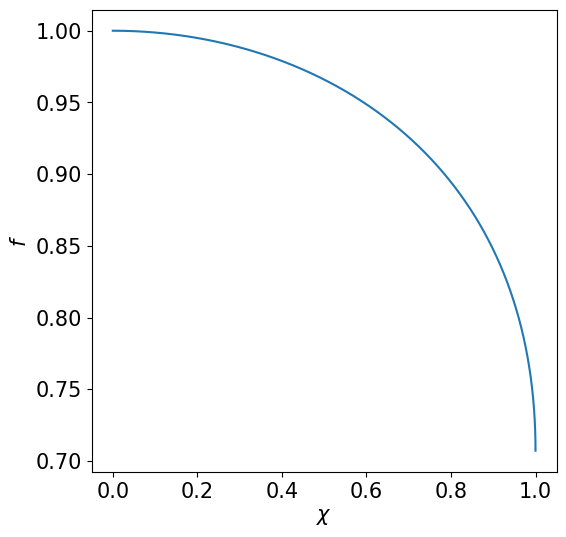

In [4]:
chi=np.linspace(0,1,N)
plt.plot(chi,littlef(chi));
plt.xlabel('$\chi$')
plt.ylabel('$f$');

Check that the distribution of $f$ is correct...

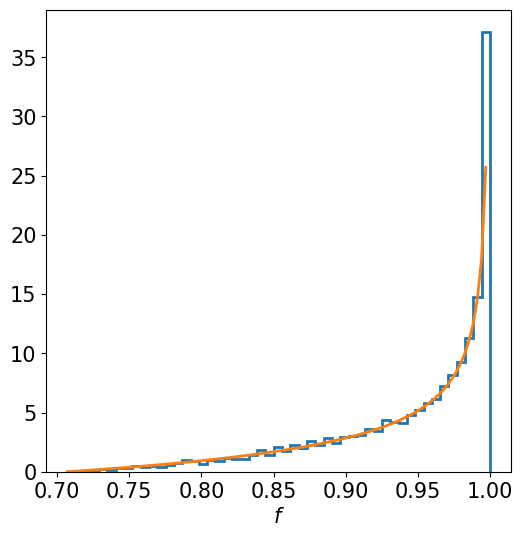

In [5]:
chi = np.random.uniform(0,1,N)[:-1]
f = littlef(chi)
plt.hist(f,density=True,bins=50, histtype='step',lw=2);

f = np.linspace(1/2**0.5,1,100)[:-1]
pdff = 2*(2*f**2-1)/(1 - f**2)**0.5
plt.plot(f,pdff,lw=2);


plt.xlabel('$f$');


The mass is Gaussian... Easy!

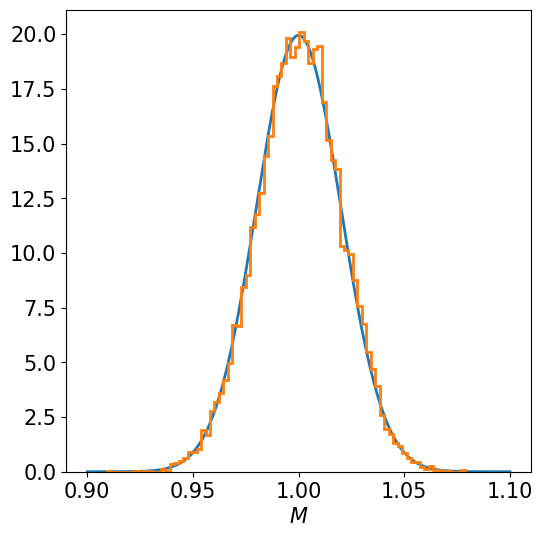

In [6]:
scale = 0.02

x = np.linspace(1-5*scale,1+5*scale,N)
M = scipy.stats.norm.pdf(x, 1, scale)
plt.plot(x,M,lw=2)

M=np.random.normal(loc=1,scale=scale,size=N)
plt.hist(M,density=True,histtype='step',bins=80,lw=2);

plt.xlabel('$M$');

Ok let's look at the irreducible mass now. Note how in this case getting the samples is much easier than getting the pdf itself. One only needs to multiply two arrays!

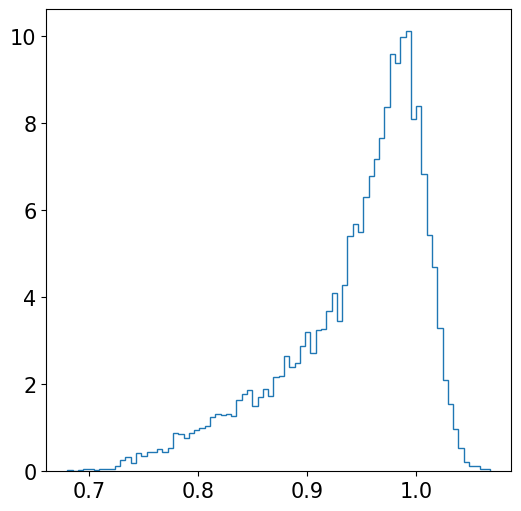

In [7]:
chi = np.random.uniform(0,1,N)
m = littlef(chi)

plt.hist(M*m,density=True,histtype='step',bins=80);

To check that what we have computed is right, we can do a numerical integral using `scipy.quad`.



  0%|          | 0/10000 [00:00<?, ?it/s]

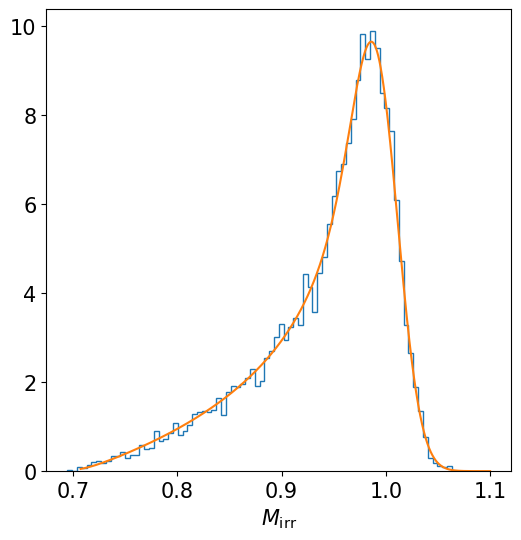

In [8]:
chi = np.random.uniform(0,1,N)
m = littlef(chi)

plt.hist(M*m,density=True,histtype='step',bins=80);

x = np.linspace(1/np.sqrt(2),1+5*scale,N)

def integrand(f,x):
    return ((2/np.pi)**0.5 / scale ) * np.exp(-(x/f -1)**2 /(2*scale**2)) * (2*f**2-1)/(1 - f**2)**0.5 / f


Mirr = [scipy.integrate.quad(lambda f: integrand(f,xt), 1/2**0.5,1)[0] for xt in tqdm(x)]

plt.plot(x,Mirr)
plt.xlabel('$M_{\\rm irr}$');

Ok it works. Now play a little bit with sigma... 

In [9]:
def plot_M_Mirr(scale):
    
    x = np.linspace(1-5*scale,1+5*scale,N)
    M = scipy.stats.norm.pdf(x, 1, scale)

    M=np.random.normal(loc=1,scale=scale,size=N)

    chi = np.random.uniform(0,1,N)
    m = littlef(chi)

    plt.hist(M*m,density=True,histtype='step',bins=80);

    x = np.linspace(min(1-5*scale,1/np.sqrt(2)),1+5*scale,N)

    def integrand(f,x):
        return ((2/np.pi)**0.5 / scale ) * np.exp(-(x/f -1)**2 /(2*scale**2)) * (2*f**2-1)/(1 - f**2)**0.5 / f

    Mirr = [scipy.integrate.quad(lambda f: integrand(f,xt), 1/2**0.5,1)[0] for xt in tqdm(x)]

    plt.plot(x,Mirr)
    plt.xlabel('$M_{\\rm irr}$');


For small sigmas this looks like the distribution of $f$

  0%|          | 0/10000 [00:00<?, ?it/s]

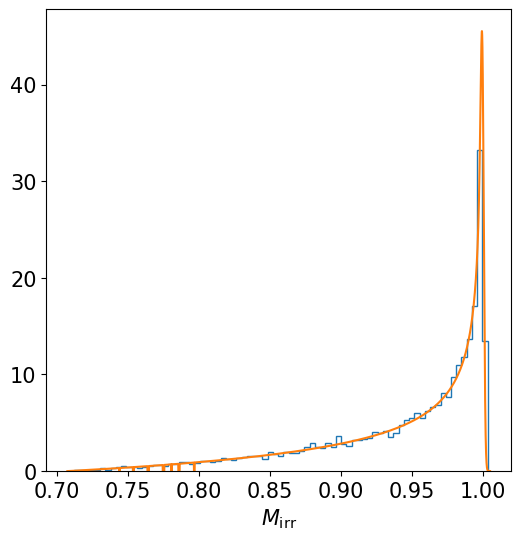

In [10]:
plot_M_Mirr(0.001)

For large sigmas this looks like the distribution of $M$ (which is a gaussian...)

  0%|          | 0/10000 [00:00<?, ?it/s]

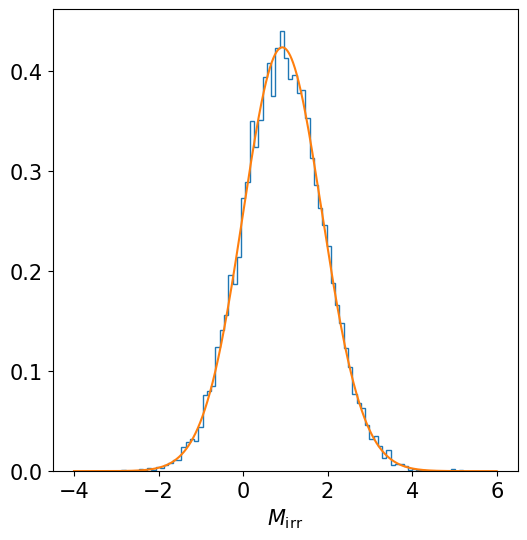

In [11]:
plot_M_Mirr(1)

These are the two limits specified in the questions... Now we have to check this with a KS test. All right.  

In [12]:
scales= np.logspace(-5,5,20)
ksM=[]
ksf = []

N=100000
chi = np.random.uniform(0,1,N)
f = littlef(chi)
for scale in tqdm(scales):

    M=np.random.normal(loc=1,scale=scale,size=N)

    ksM.append(scipy.stats.ks_2samp(M, M*f))
    ksf.append(scipy.stats.ks_2samp(m, M*f))

ksM= np.array(ksM)
ksf= np.array(ksf)

  0%|          | 0/20 [00:00<?, ?it/s]

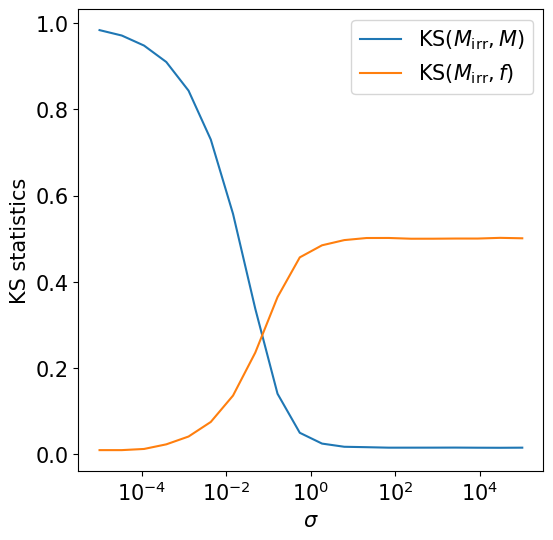

In [13]:
plt.plot(scales,ksM[:,0],label="KS$(M_{\\rm irr}, M)$")
plt.plot(scales,ksf[:,0],label="KS$(M_{\\rm irr}, f)$")
plt.semilogx()
plt.xlabel("$\sigma$")
plt.ylabel('KS statistics')
plt.legend();

- For small $\sigma$, $M_{\rm irr}$ is distributed like $M$ (i.e. their KS distance goes to zero)
- For large $\sigma$, $M_{\rm irr}$ is distributed like $f$ (i.e. their KS distance goes to zero)

## KDE representation

In [14]:
N=10000

scale=0.02


x = np.linspace(1-5*scale,1+5*scale,N)
M = scipy.stats.norm.pdf(x, 1, scale)
#plt.plot(x,M,lw=2)

M=np.random.normal(loc=1,scale=scale,size=N)

chi = np.random.uniform(0,1,N)
m = littlef(chi)

x = np.linspace(min(1-5*scale,1/np.sqrt(2)),1+5*scale,N)

def integrand(f,x):
    return ((2/np.pi)**0.5 / scale ) * np.exp(-(x/f -1)**2 /(2*scale**2)) * (2*f**2-1)/(1 - f**2)**0.5 / f

Mirr = [scipy.integrate.quad(lambda f: integrand(f,xt), 1/2**0.5,1)[0] for xt in tqdm(x)]


  0%|          | 0/10000 [00:00<?, ?it/s]

In [15]:
# Load the KDE module
from sklearn.neighbors import KernelDensity
#xgrid = np.linspace(x.min(),x.max(),N)  # Use this instead of 'x' for plotting

def kde_sklearn(data, bandwidth = 1.0, kernel="linear"):
    kde_skl = KernelDensity(bandwidth = bandwidth, 
                            kernel=kernel)
    kde_skl.fit(data[:, np.newaxis])
    log_pdf = kde_skl.score_samples(x[:, np.newaxis]) # sklearn returns log(density)

    return np.exp(log_pdf)

  0%|          | 0/3 [00:00<?, ?it/s]

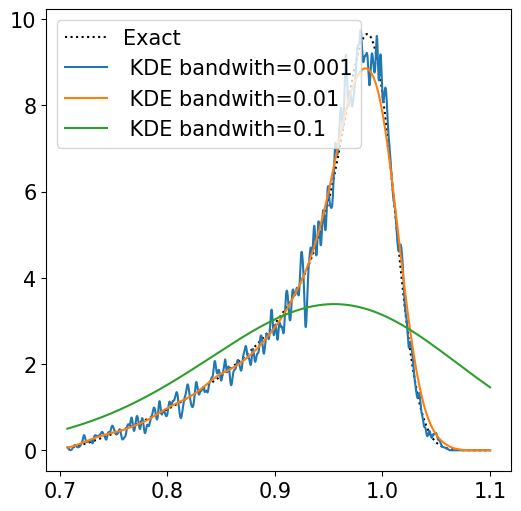

In [16]:
plt.plot(x,Mirr,label='Exact',c='black',ls='dotted')


for bandwith in tqdm([0.001,0.01,0.1]):
    kdepdf = kde_sklearn(M*m,bandwidth=bandwith,kernel="gaussian")

    plt.plot(x,kdepdf,label=' KDE bandwith='+str(bandwith))

plt.legend();